# Import the python libraries

In [ ]:
pip install pyspellchecker

In [ ]:
# Download NLTK Copora
import nltk
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')

#Data Analysis
import pandas as pd
import numpy as np
import collections
from collections import Counter

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
import string
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from nltk.tokenize import TweetTokenizer
from nltk import SnowballStemmer
stopword = nltk.corpus.stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Import the data to a pandas dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load train data
train = pd.read_csv('/content/drive/My Drive/Climate Change Belief Analysis/climate-change-edsa2020-21 (1)/train.csv')
# load test data
test = pd.read_csv('/content/drive/My Drive/Climate Change Belief Analysis/climate-change-edsa2020-21 (1)/test.csv')

# Exploratory Data Analysis

In [ ]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [ ]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [ ]:
# Train Dataset
print('Dataset size:',train.shape)
print('Columns are:',train.columns)

# Test Dataset
print('Dataset size:',test.shape)
print('Columns are:',test.columns)

Dataset size: (15819, 3)
Columns are: Index(['sentiment', 'message', 'tweetid'], dtype='object')
Dataset size: (10546, 2)
Columns are: Index(['message', 'tweetid'], dtype='object')


In [ ]:
test.isnull().sum()
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


Explore distribution of sentiments

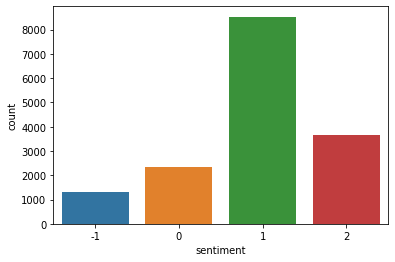

In [ ]:
sns.countplot(x = 'sentiment', data = train)

In [ ]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
train['word count'] = train['message'].apply(word_count)
train.head()

,sentiment,message,tweetid,word count
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,19
1,1,It's not like we lack evidence of anthropogeni...,126103,10
2,2,RT @RawStory: Researchers say we have three ye...,698562,19
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,15
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,18


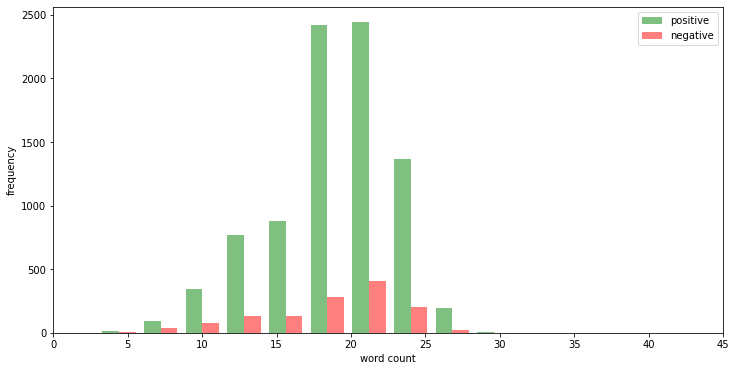

In [ ]:
# plot word count distribution for both Pro and Anti climate change sentiments
x = train['word count'][train.sentiment == 1] # Pro climate change
y = train['word count'][train.sentiment == -1] # Anti climate change

plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

Count Words in each sentiment 

In [ ]:
# get most common words in training dataset
all_words = []
for line in list(train['message']):
  words = line.split()
  for word in words:
    all_words.append(word.lower())

Counter(all_words).most_common(5)

[('climate', 12323),
 ('rt', 9707),
 ('change', 8883),
 ('the', 7573),
 ('to', 7139)]

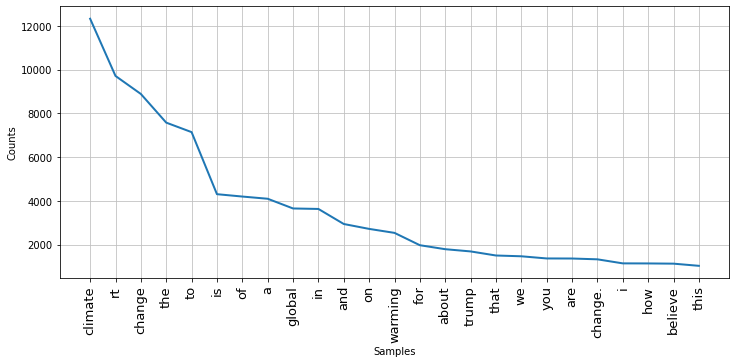

<Figure size 864x360 with 0 Axes>

In [ ]:
# most common words in twitter dataset
all_words = []
for line in list(train['message']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True),plt.figure(figsize=(12,5))

# Text Data Cleaning

In [ ]:
# Combine Train and Test data to avoid doing the same steps on each dataset
combi = train.append(test, ignore_index=True)

# text lower case to remove some noise from capitalisation
combi['clean_tweets'] = combi['message'].str.lower()

# Basic Cleaning 
def remove_whitespace(tweet):
  """ Custom function to conver user handles, remove white space and hyperlinks"""
  #Convert @username to AT_USER
  tweet = re.sub('@[^\s]+','',tweet)
  # Remove whitespace (including new line characters)
  tweet = re.sub(r'\s\s+', ' ', tweet)
  # Remove hyperlinks
  tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
  return tweet
combi['clean_tweets'] = combi['clean_tweets'].apply(remove_whitespace)

Chat Words Conversion

In [ ]:
chat_words_map_dict = {}
chat_words_list = []
for line in combi['clean_tweets']:
    if line != "":
        cw = line.split("=")[0]
        cw_expanded = line.split("=")[0]
        chat_words_list.append(cw)
        chat_words_map_dict[cw] = cw_expanded
chat_words_list = set(chat_words_list)

def chat_words_conversion(text):
    """This function change abbreviated words in chat tweets"""
    new_text = []
    for w in text.split():
        if w.upper() in chat_words_list:
            new_text.append(chat_words_map_dict[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)

# apply the function on tweets column
combi['clean_tweets'] = combi['clean_tweets'].apply(chat_words_conversion)

Correct Spelling

In [ ]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

combi['clean_tweets'] = combi['clean_tweets'].apply(lambda text: chat_words_conversion(text))

Removing Punctuations, Numbers, and Special Characters

In [ ]:
def remove_punctuation(text):
  """custom function to remove the punctuation"""
  return ''.join([l for l in text if l not in string.punctuation])

# apply remove_punctuation function on the combined database
combi['clean_tweets'] =  combi['clean_tweets'].apply(remove_punctuation) 

# Removing Short Words (e.g " 'oh','rt' or 'hmm'")
combi['clean_tweets'] = combi['clean_tweets'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))


Remove None Sense Words

In [ ]:
words = set(nltk.corpus.words.words())

def nonsense_words(text):
    text= re.sub(r'https.?://[^\s]+[\s]?', '', text)
    return " ".join(w for w in nltk.wordpunct_tokenize(text) \
     if w.lower() in words or not w.isalpha())

combi['clean_tweets'] = combi['clean_tweets'].apply(nonsense_words)

Create Custom Functions For:

*   Tokenization
*   Stemming
*   Removing Stop Words





In [ ]:
# Tokenizing words Tweets
def tokenize(clean_tweet):
  """ This function create tokens using word_tokenize"""
  return nltk.word_tokenize(clean_tweet)

# Stemming words Tweets
stemmer = SnowballStemmer('english')

def stemming(words, stemmer):
  """ This function find the stem of each word in tweets 
              using Snowball algorithms"""
  return [stemmer.stem(word) for word in words]

# Lemmatizing words Tweets
lemmatizer = WordNetLemmatizer()

def lemma(words, lemmatizer):
  """ This function lemmatize each word in tweets"""
  return [lemmatizer.lemmatize(word) for word in words]

# Remove Stop Words
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
  """The following function removes all of the English stopwords from the input text"""
  text = [word for word in text if word not in stopword]
  return text

Create a DaFrame For Clean Tweets

In [ ]:
# Tokenize Tweets
combi['tokenized_tweets'] = combi['clean_tweets'].apply(tokenize) 

# Remove Stop Words
combi['nonstop_tweets'] =  combi['tokenized_tweets'].apply(remove_stopwords)

# Stemming Tweets
combi['stemmed_tweets'] = combi['nonstop_tweets'].apply(stemming, args=(stemmer, ))

combi.head()

,sentiment,message,tweetid,word count,clean_tweets,tokenized_tweets,nonstop_tweets,stemmed_tweets
0,1.0,PolySciMajor EPA chief doesn't think carbon di...,625221,19.0,chief doesnt think carbon dioxide main cause g...,"[chief, doesnt, think, carbon, dioxide, main, ...","[chief, doesnt, think, carbon, dioxide, main, ...","[chief, doesnt, think, carbon, dioxid, main, c..."
1,1.0,It's not like we lack evidence of anthropogeni...,126103,10.0,like lack evidence anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, ...","[like, lack, evidence, anthropogenic, global, ...","[like, lack, evid, anthropogen, global, warm]"
2,2.0,RT @RawStory: Researchers say we have three ye...,698562,19.0,have three climate change before it ’ s late,"[have, three, climate, change, before, it, ’, ...","[three, climate, change, ’, late]","[three, climat, chang, ’, late]"
3,1.0,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,15.0,wired 2016 pivotal year climate change,"[wired, 2016, pivotal, year, climate, change]","[wired, 2016, pivotal, year, climate, change]","[wire, 2016, pivot, year, climat, chang]"
4,1.0,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,18.0,2016 racist climate change bigot leading,"[2016, racist, climate, change, bigot, leading]","[2016, racist, climate, change, bigot, leading]","[2016, racist, climat, chang, bigot, lead]"


In [ ]:
def clean_text(text):
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [stemmer.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [ ]:
vectorizer = CountVectorizer(analyzer=clean_text) 
countVector = vectorizer.fit_transform(combi['stemmed_tweets'].ravel())
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))
#print(countVectorizer.get_feature_names())

26365 Number of tweets has 21146 words


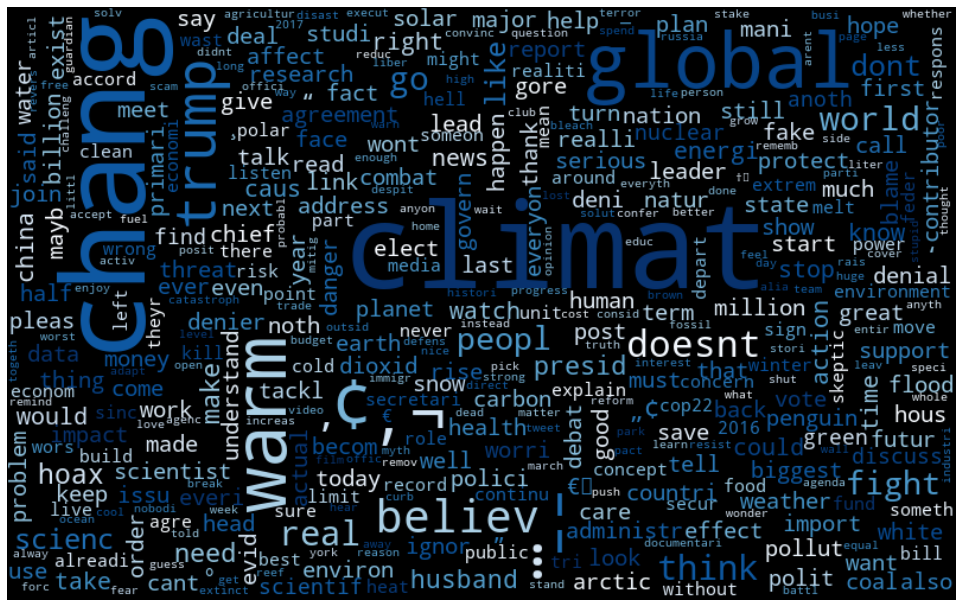

In [ ]:
# split sentences to get individual words
all_words = []
for line in combi['stemmed_tweets']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=800,
                      height=500,
                      max_words=400,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Feature Creation 

In [ ]:
# vectorize
bow_transformer = CountVectorizer(analyzer = clean_text).fit(combi['stemmed_tweets'])

# print total number of vocab words
print(len(bow_transformer.vocabulary_))
# output
21146

# example of vectorized text
sample_tweet = combi['stemmed_tweets'][150]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

21146
['erupt', 'climat', 'chang', 'video', 'time', 'call', 'trump', 'heritag', '…']


  (0, 0)	1
  (0, 6478)	1




Transform the whole DataFrame

In [ ]:
messages_bow = bow_transformer.transform(combi['stemmed_tweets'])

# check bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (26365, 21146)
Amount of Non-Zero occurences:  37962


Term Frequency, Inverse Document Frequency (TF-IDF)

In [ ]:
# from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)

  (0, 6478)	0.9814739575587741
  (0, 0)	0.19159559137390883


Example of IDF

In [ ]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['climat']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['chang']])

8.61488122285638
10.48668339975797


Transform the whole bag-of-words into TF-IDF Corpus

In [ ]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(26365, 21146)


# Model Training 

In [ ]:
# Run Train Data Through Pipeline analyzer=text_process
# uncomment below to train on a larger dataset but it's very slow for a slower machine.
# X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(combi['message'][:5000],  combi['sentiment'][:5000], test_size=0.2)
# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words = 'english',
                            lowercase=True)), # string to take inter count
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB())  # train on TF-IDF vectors w/ Naive Bayes classifier
])
# Define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }
# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   13.0s finished



Best Model: 0.688000 using {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.659500 Stdev:(0.012135) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.669500 Stdev:(0.016948) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.650750 Stdev:(0.012044) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.659000 Stdev:(0.013519) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.676250 Stdev:(0.012412) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.688000 Stdev:(0.012237) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.667750 Stdev:(0.018556) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.678750 Stdev:(0.013613) with: {'bow__ngram_range'

# Model Evaluation


In [ ]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")

# load from file and predict using the best configs found in the CV step
naive_bayes_model = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = naive_bayes_model.predict(X_test)
print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.688


confusion matrix: 
 [[ 17  11  36   5]
 [  2  42  95  11]
 [  1  19 483  58]
 [  1   3  70 146]]


              precision    recall  f1-score   support

        -1.0       0.81      0.25      0.38        69
         0.0       0.56      0.28      0.37       150
         1.0       0.71      0.86      0.78       561
         2.0       0.66      0.66      0.66       220

    accuracy                           0.69      1000
   macro avg       0.68      0.51      0.55      1000
weighted avg       0.68      0.69      0.66      1000



In [ ]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test,y_preds, average="macro")

0.5476627723013265

In [ ]:
testx = test['message']
test_vect = vectorizer.transform(testx)

In [ ]:
y_pred = naive_bayes_model.predict(testx)

In [ ]:
test['sentiment'] =  y_pred

In [ ]:
test.head()

,message,tweetid,sentiment
0,Europe will now be looking to China to make su...,169760,1.0
1,Combine this with the polling of staffers re c...,35326,1.0
2,"The scary, unimpeachable evidence that climate...",224985,2.0
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263,1.0
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928,1.0


In [ ]:
test[['tweetid','sentiment']].to_csv('test_submission_3.csv',index=False)